##  Research on the optimization of multi-class land cover classification using deep learning with multispectral imagery

Yichuan Li, [Junchuan Yu*](https://github.com/JunchuanYu), Ming Wang, Minying Xie, Laidian Xi, Yunxuan Pang, and Changhong Hou

*corresponding author:yujunchuan@mail.cgs.gov.cn


Code:   [Github](https://github.com/JunchuanYu/OUNet_for_multi-class_land_cover_classification)



### Part1: Baseline solution

In [1]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import time,glob
import os
from model import all_model
from utils import *

#### 1. Load and check data 


In [2]:
## load rgb data
hdf5_path = "./data/kaggle_14_8b_5c.hdf5"
fd = h5py.File(hdf5_path, 'r')
fd.keys()
images=fd['image']
labels=fd['label']
n_label=len(np.unique(labels)) #{0:'buiding',1:'Road', 2:'Tree',3: 'Crops',4:'Water'}
print(np.max(images),np.min(images),np.max(labels),np.min(labels))
images=np.array(images)[:,:,:,:3] #load rgb data
labels=np.array(labels)
print(images.shape,labels.shape)


9995 38 4 0
(14, 3840, 3840, 3) (14, 3840, 3840)


In [29]:
# Normalization
def stretch_n(band, lower_percent=5, higher_percent=95): #5和95表示分位数
    band=np.array(band,dtype=np.float32)
    c = np.percentile(band, lower_percent)*1.0
    d = np.percentile(band, higher_percent)*1.0       
    band[band<c] = c
    band[band>d] = d
    out =  (band - c)  / (d - c)  
    return out.astype(np.float32)

def adjust_contrast(data,n_band=3):    #通过循环对各个波段进行拉伸
    data=np.array(data,dtype=np.float32)
    for img in data:
        for k in range(n_band):
            img[:,:,k] = stretch_n(img[:,:,k])
    return data

newimg=adjust_contrast(images.copy()) #该操作讲改变原始数据，因此用.copy，不对原始数据进行更改
print(np.max(images),np.max(newimg))

9995 1.0


9995 9995.0


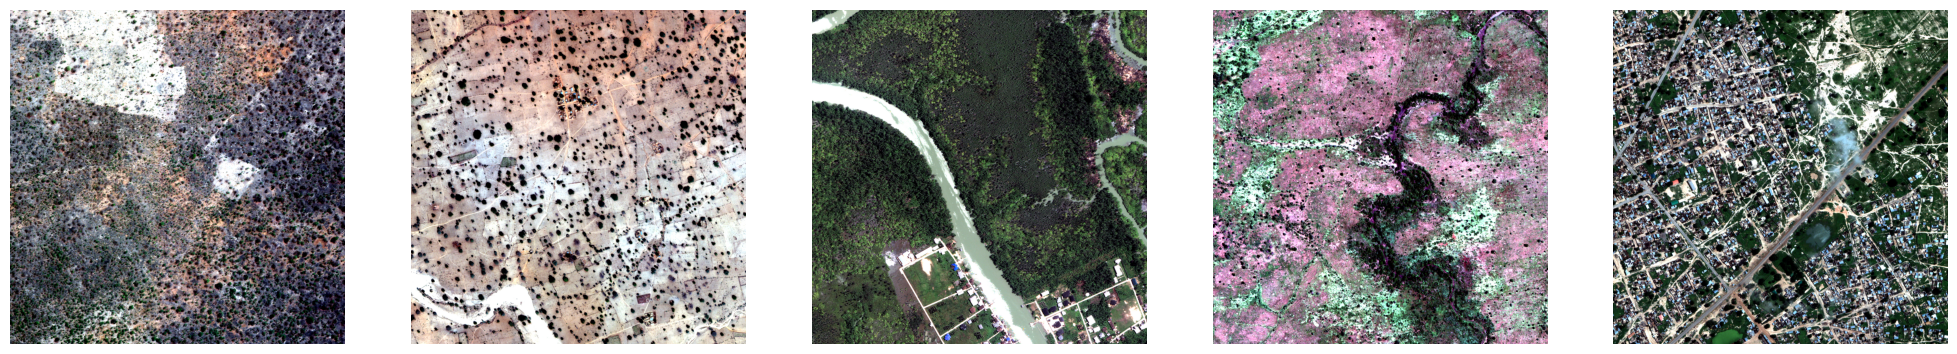

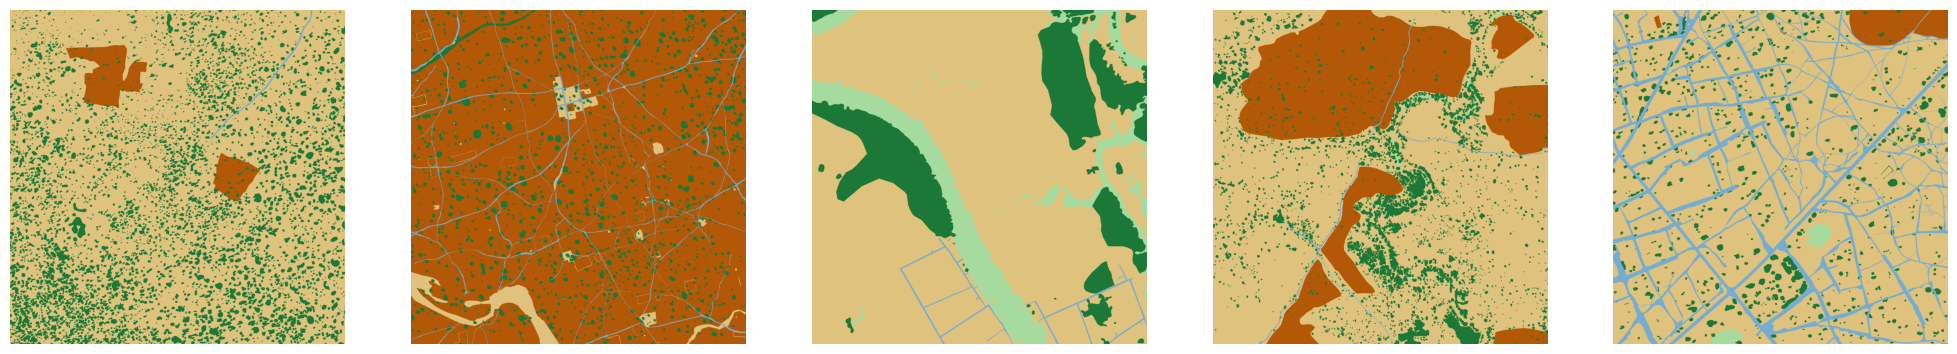

In [4]:
# Show image

def show_5_images(image,label=None,n=1):
    palette = np.array([ [223,194,125],   [116,173,209],   [27,120,55], [179,88,6], [166,219,160]]) 
    color=palette[label]
    for k in range(n):
        fig=plt.figure(figsize=(25,30))
        for i in range(5):
            plt.subplot(k+1,5,k*5+i+1)
            plt.imshow((image[k*5+i,:,:,:3]))
            plt.grid (False)
            plt.axis('off')
        plt.show()
        if label is not None:
            fig=plt.figure(figsize=(25,30))
            for i in range(5):
                plt.subplot(k+1,5,k*5+i+1)
                plt.imshow(color[k*5+i,:,:])
                plt.grid (False)
                plt.axis('off')
        plt.show()   
show_5_images(newimg,labels)


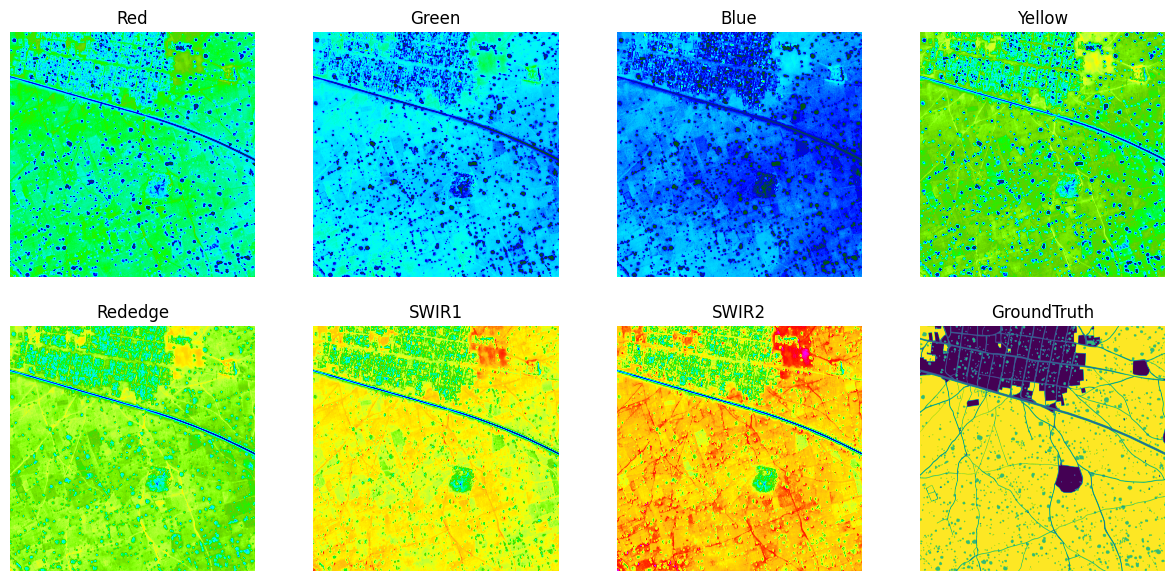

In [5]:
# show image band
def Plot_Image_Allband(img,label):  
    plt.figure(figsize=[15,7])
    name_list = ['Red','Green','Blue','Yellow','Rededge','SWIR1','SWIR2']
    for i in range(1,8):
        plt.subplot(2,4,i)
        # plt.rcParams['font.sans-serif']=['SimHei']    # 用来设置字体样式以正常显示中文标签
        # plt.rc('font',family='SimHei',size=16)
        plt.imshow(img[:, :, i-1],cmap=plt.get_cmap('gist_ncar'))
        plt.title(name_list[i-1])
        plt.axis('off')
    plt.subplot(2,4,8)
    plt.imshow(label)
    plt.title('GroundTruth')
    plt.axis('off')
    plt.show() 
Plot_Image_Allband(images[8,:,:,:],labels[8,:,:])

#### 2. Crop and Get data patches

In [30]:
##sequential crop
def sequential_crop(imagearray,crop_sz,step=256):
    data = []
    x=0
    row_num = ((imagearray.shape)[0] - step) // step  ##最多能裁剪几行 几列
    col_num=((imagearray.shape)[1] - step) // step
    x_start=0
    y_start=0
    for h in range(row_num):
        for w in range(col_num):
            crop_img = imagearray[crop_sz*h+y_start:crop_sz*(h+1)+y_start, crop_sz*w+x_start:crop_sz*(w+1)+x_start,:] ##行列循环，滑动窗口移动              
            data.append(crop_img)
            x=x+1
    data=np.array(data)
    return data
def data_crop(imagearray,crop_sz,stride,random=False,n_patch=250):   #设置random选项，用来切换是否采用随机裁切
    data = []
    for i in range(imagearray.shape[0]):
        if random:
            image=data_crop_random(imagearray[i,:,:,:],crop_sz,n_patch)
        else:
            image =sequential_crop(imagearray[i,:,:,:],crop_sz,stride)
        if i == 0:
            data  = image ##注意当i=0的时候需要将image赋给data，否则data依然是空，不可以进行concatnate
        else:
            data  = np.concatenate((data, image), axis = 0) 
        print("patch processing....:"+str(i))
    data=np.array(data,dtype=np.float32)
    print("final processed:"+str(i)+"...No.:"+str(data.shape[0]))    
    return data


In [31]:
## 合并images和labels方便切片
data_all = np.concatenate((newimg, np.expand_dims(labels,axis=-1)), axis = -1)
stride=256
cropsize=256
all_patches=data_crop(data_all,cropsize,stride)##保留2景数据做测试
print(data_all.shape,all_patches.shape)
i=0
all_patches=suffle_data(all_patches) #对数据进行打乱处理

patch processing....:0
patch processing....:1
patch processing....:2
patch processing....:3
patch processing....:4
patch processing....:5
patch processing....:6
patch processing....:7
patch processing....:8
patch processing....:9
patch processing....:10
patch processing....:11
patch processing....:12
patch processing....:13
final processed:13...No.:2744
(14, 3840, 3840, 4) (2744, 256, 256, 4)
(2744, 256, 256, 4)


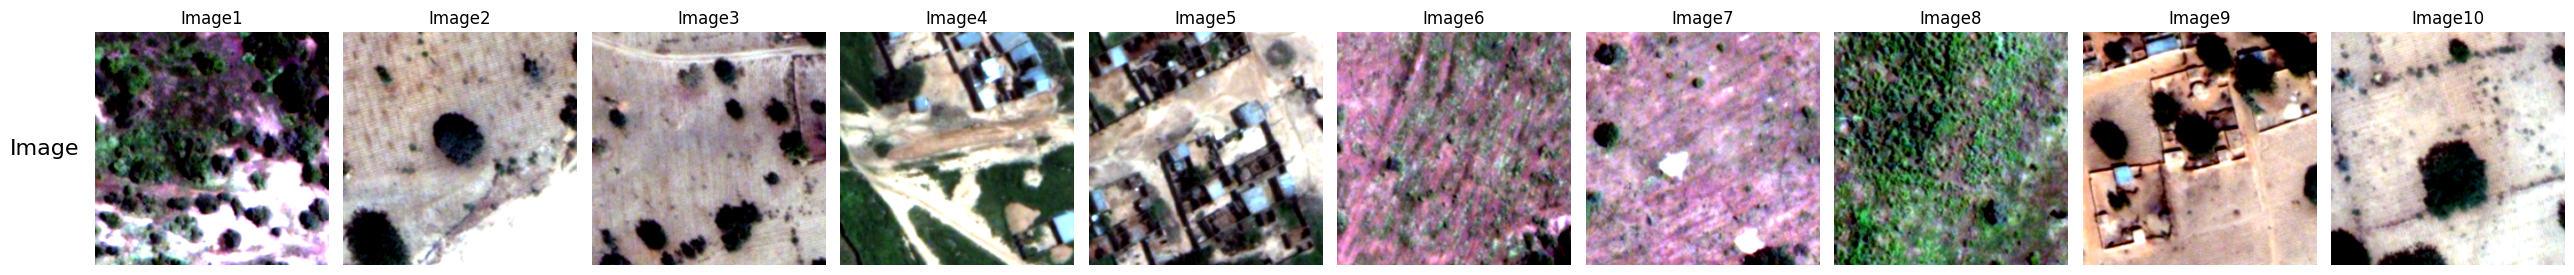

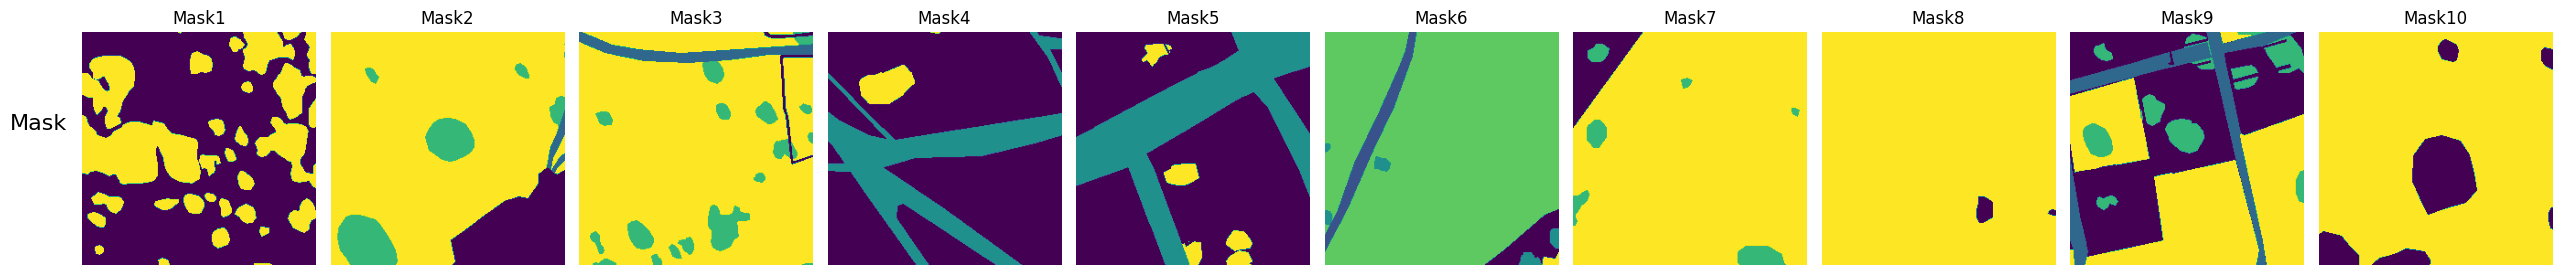

In [10]:
## plot the patches
plot_func(all_patches[i:i+20,:,:,:3],all_patches[i:i+20:,:,:,-1])
i+=500

In [10]:
## save to hdf5
# hdf5_path = './patches_mul_3b_5c.hdf5' 
# f = h5py.File(hdf5_path, mode='w')
# f['image'] = all_patches[:,:,:,0:-1]
# f['label'] = all_patches[:,:,:,-1]
# f.close()

#### 3. Model training

In [11]:
## load hdf5
# hdf5_path = './patches_mul_3b_5c.hdf5' 
# fd = h5py.File(hdf5_path, 'r')
# fd.keys()
# images=np.array(fd['image'])
# labels=np.array(fd['label'])


In [36]:
## turn label into one-hot label
def post_normalize_image(images,labels,n_label=n_label):
    msk = label_hot(labels,n_label)
    img = images
    return img,msk
# img,msk=post_normalize_image(images,labels,n_label)
img,msk=post_normalize_image(all_patches[:,:,:,0:-1],all_patches[:,:,:,-1],n_label)
## split the datset into training and testing
xtrain,xtest,ytrain,ytest=train_test_split(img,msk,test_size=0.2,random_state=42)
del img,msk,data_all,all_patches,images,newimg 
print(xtrain.shape,xtest.shape,ytrain.shape,ytest.shape)
i=0

(2195, 256, 256, 3) (549, 256, 256, 3) (2195, 256, 256, 5) (549, 256, 256, 5)


In [14]:
## setting
loss='categorical_crossentropy'
optimizer=Adam()
loss_weights=''
metrics=['accuracy']
batch_size=10
epoch= 50
input_height=xtrain.shape[1]
input_width=xtrain.shape[2]
nchannel=xtrain.shape[-1]
num_train=xtrain.shape[0]
num_val=xtest.shape[0]
ATM=all_model(loss,loss_weights,optimizer,metrics,input_height,input_width,n_label,nchannel) #向all_model传参返回模型
modelname='baseline'

In [17]:
## load model
model=ATM.UNET()
# model.summary()

In [ ]:
## training
begin_time = time.time()          
out_dir = "./checkpoint/"+modelname+'/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir) 

model_checkpoint = ModelCheckpoint(filepath=out_dir+modelname+".hdf5",monitor="val_loss",save_best_only=True,mode='auto')

## save history
csvlogger =CSVLogger(filename=out_dir+modelname+'-'+str(epoch)+'-log.csv', separator=',', append=False)
result=model.fit(xtrain, ytrain, batch_size=batch_size, epochs=epoch, verbose=1, shuffle=True,validation_data=(xtest, ytest),callbacks=[model_checkpoint,csvlogger])
end_time = time.time()
print('time lapsing {0} s \n'.format(end_time - begin_time))

#### 4 Evalution

In [5]:
## load the best checkpoint
h5=glob.glob("./checkpoint/"+modelname+"/*.hdf5")
model_list=np.sort(h5)
model=load_model(model_list[-1])
print(model_list[-1])

./checkpoint/baseline\-24e-val_loss0.424916.hdf5


In [38]:
i=100
pred=model.predict(xtest,batch_size=64)
pred=np.argmax(pred,axis=-1)
gt=np.argmax(ytest,axis=-1)

9/9 [==============================] - 2s 156ms/step


In [40]:
##  Accuracy Evaluation
df = call_matric(pred,gt, [0,1,2,3,4, 'all'])
print(df)

     precision    recall  F1-score       iou        oa      miou
0     0.878429  0.925386  0.901296  0.820327  0.878125  0.600206
1     0.732757  0.288294  0.413788  0.260866  0.878125  0.600206
2     0.774869  0.730048  0.751791  0.602296  0.878125  0.600206
3     0.907964  0.951971  0.929447  0.868193  0.878125  0.600206
4     0.749662  0.528679  0.620070  0.449349  0.878125  0.600206
all   0.808736  0.684876  0.723279  0.600206  0.878125  0.600206


#### 5. Prediction results visulization

In [6]:
data=np.load(r'./data/patch_test.npy')
print(data.shape,np.max(data))

(8, 256, 256, 8) 4.0


In [ ]:
## patch prediction visulization
pred=model.predict(data[:,:,:,:3],batch_size=64)
pred=np.argmax(pred,axis=-1)
gt=np.argmax(data[:,:,:,-1],axis=-1)

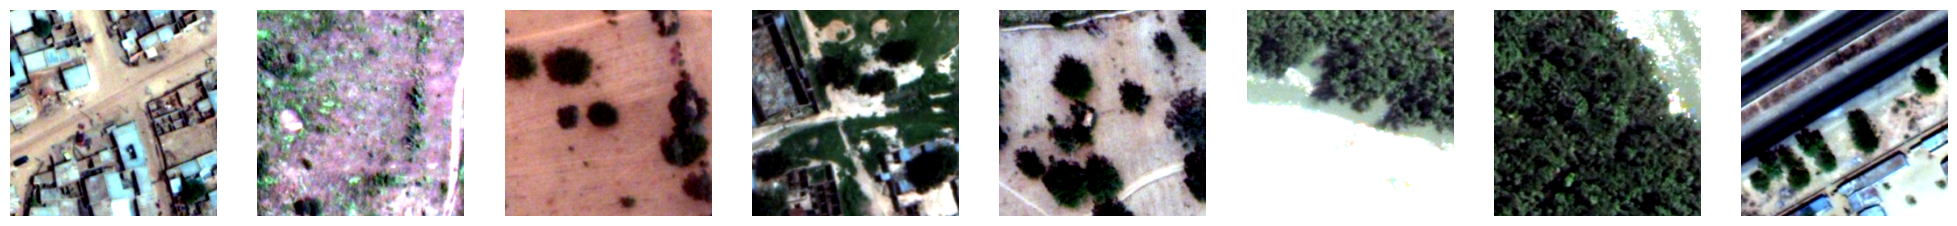

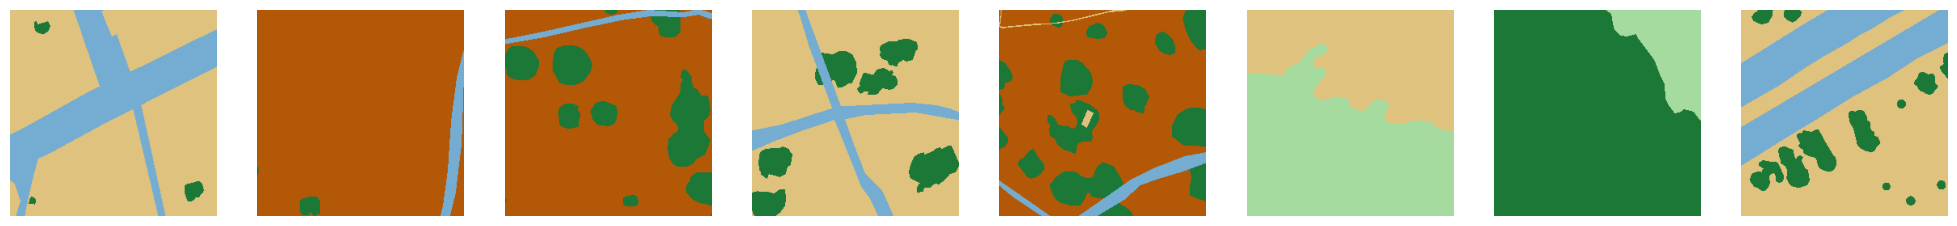

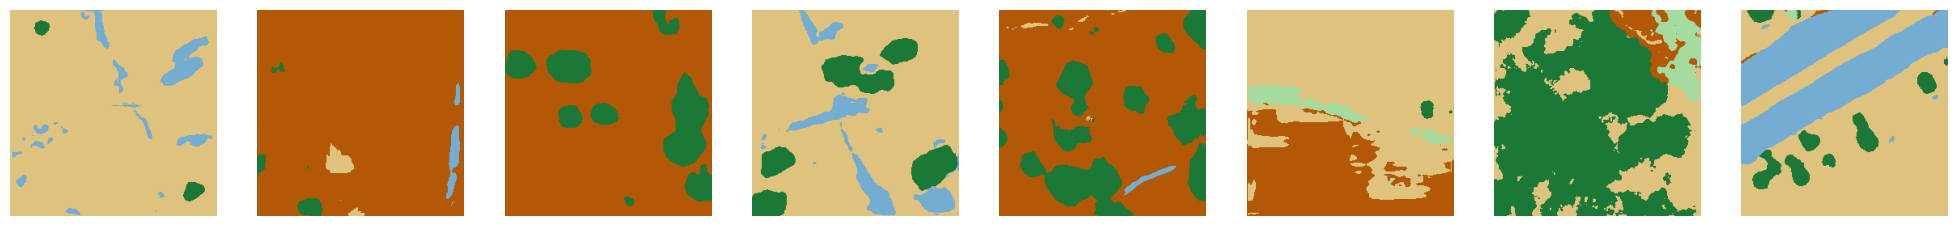

In [50]:
palette = np.array([ [223,194,125],   [116,173,209],   [27,120,55], [179,88,6], [166,219,160]]) 
predc=palette[pred]
gt=np.array(data[:,:,:,-1],dtype=np.uint8)
gtc=palette[gt]

new_val_plot(data,gtc,predc)

In [6]:
## image prediction visulisation
## load imgage
test_data  = h5py.File('./data/kaggle_test1_8b_5c.hdf5', 'r')
testimg = np.array(test_data['image'])[:,:,:,:3]
testlabel=np.array(test_data['label'])
print(testimg.shape,testlabel.shape)

(1, 3840, 3840, 3) (1, 3840, 3840)


In [7]:
image=adjust_contrast(testimg,n_band=testimg.shape[-1])
np.max(image),np.max(testimg)

(1.0, 9995)

In [8]:
predicts=[]
for i in range(image.shape[0]):
    h_pred = center_predict(image[0],model,32,n_label)
    h_pred_mask=np.argmax(h_pred, axis = -1)
    palette = np.array([ [223,194,125],   [116,173,209],   [27,120,55], [179,88,6], [166,219,160]]) 
    predc=palette[h_pred_mask]
    predicts.append(predc)  
result=np.array(predicts)

31/31 [==============================] - 7s 86ms/step
pred_time: 10.148523807525635


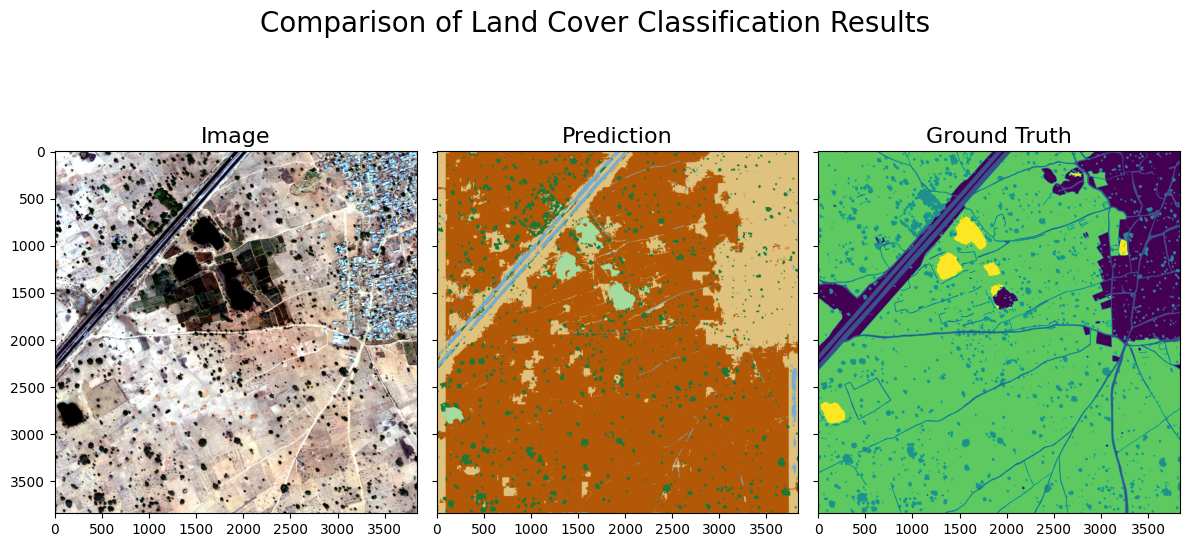

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(12,10))
axs[0].imshow(image[0,:,:,:3])
axs[0].set_title('Image', fontsize=16)
axs[1].imshow(result[0])
axs[1].set_title('Prediction', fontsize=16)
axs[2].imshow(testlabel[0])
axs[2].set_title('Ground Truth', fontsize=16)

for ax in fig.get_axes():
    ax.label_outer()
    ax.ticklabel_format(style ='plain') 
fig.tight_layout()
fig.suptitle('Comparison of Land Cover Classification Results', fontsize=20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=1.3, wspace=None, hspace=0.2)